In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "../../data/SP500_EGS_Score_avarage_per_year.csv",
    index_col=0,
    parse_dates=True,
    sep=",",
)

In [ ]:
df.head(20)

In [ ]:
# all lower case

df.columns = map(str.lower, df.columns)

# - to _

df.columns = df.columns.str.replace("-", "_")

In [ ]:
len(df.company_symbol.unique())

In [ ]:
import sys

sys.path.append("../")

In [ ]:
from helpers.text_preprocessing.preprocess_text import preprocess_text

In [ ]:
import pandas as pd

# Load or create your DataFrame (replace 'your_data.csv' with the path to your data file)
df = pd.read_csv(
    "../data/extracted_text_sustainability_reports.csv",
    index_col=0,
    parse_dates=True,
    sep=",",
)

In [ ]:
# Preprocess the text and get the preprocessed DataFrame
preprocessed_df = preprocess_text(df)

In [ ]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import plotly
from gensim import corpora
import mlflow

In [ ]:
import sys

sys.path.append("../")

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
df = pd.read_csv("../data/ready_to_model/df_filtered_feature_importance.csv")


In [ ]:
df

In [4]:
df.fillna(0, inplace=True)

In [5]:
'''  "e_score",
    "s_score",
    "g_score",
    "unnamed: 0",
    "filename",
    "ticker",
    "year",
    "preprocessed_content",
    "ner_entities",
    "company_symbol"'''


# columns to drop
columns_to_drop = [

    "total_score",
    "Unnamed: 0",
]

# Separate features and target
y = df["total_score"]
X = df.drop(columns=columns_to_drop)

In [ ]:
X

In [6]:
# drop the last two rows
X = X.iloc[:-2, :]

In [7]:
y = y.iloc[:-2]

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [ ]:
y

In [9]:
import sys

sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")



In [10]:
from models.XGBoost.tune_xgb_hyperparameters import tune_xgb_hyperparameters
from models.ElasticNet.tune_elasticnet_hyperparameters import tune_elasticnet_hyperparameters
from models.GradientBoostingReg.tune_gradientboosting_hyperparameters import tune_gradientboosting_hyperparameters
from models.LightGBM.tune_lightgbm_hyperparameters import tune_lightgbm_hyperparameters
from models.Lasso.tune_lasso_hyperparameters import tune_lasso_hyperparameters
from models.Ridge.tune_ridge_hyperparameters import tune_kernelridge_hyperparameters
from models.perform_stacking import perform_stacking


In [ ]:
#classification
from models.classification_model.tune_xgb_hyperparameters_cf import tune_xgb_hyperparameters_cf
from models.classification_model.train_and_evaluate import train_and_evaluate

In [ ]:
best_params = tune_xgb_hyperparameters_cf(X_train, y_train, X_test, y_test, 20, 5)

In [ ]:
import pickle

In [ ]:
with open("../models/classification_model/best_params_xgb_cf.pkl", "rb") as f:
    best_params = pickle.load(f)

In [ ]:
trained_model = train_and_evaluate(X_train, y_train, X_test, y_test, best_params)

# REGRESSION

In [ ]:
tune_elasticnet_hyperparameters(X_train, y_train, X_test, y_test, n_trials=25)

In [ ]:
tune_xgb_hyperparameters(X_train, y_train, X_test, y_test, n_trials=25, n_jobs=5)
# [I 2023-10-09 11:51:29,849] Trial 11 finished with value: 4.829379390412605 and parameters: {'learning_rate': 0.005751799616059423, 'max_depth': 15, 'subsample': 0.7721631821405752, 'colsample_bytree': 0.9734742381013841, 'min_child_weight': 5}. Best is trial 11 with value: 4.829379390412605.
# Training RMSE: 5.181233593282065, Test RMSE: 4.829379390412605

In [ ]:
tune_gradientboosting_hyperparameters(X_train, y_train, X_test, y_test, n_trials=20)

In [ ]:
tune_lightgbm_hyperparameters(X_train, y_train, X_test, y_test, n_trials=25)

In [ ]:
tune_lasso_hyperparameters(X_train, y_train, X_test, y_test, n_trials=25)

In [ ]:
tune_kernelridge_hyperparameters(X_train, y_train, X_test, y_test, n_trials=40)

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8842062027643025, colsample_bytree=0.6108477544300839 will be ignored. Current value: feature_fraction=0.8842062027643025
[LightGBM] [Warning] bagging_fraction is set=0.912287269876001, subsample=0.6618858329773405 will be ignored. Current value: bagging_fraction=0.912287269876001
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8842062027643025, colsample_bytree=0.6108477544300839 will be ignored. Current value: feature_fraction=0.8842062027643025
[LightGBM] [Warning] bagging_fraction is set=0.912287269876001, subsample=0.6618858329773405 will be ignored. Current value: bagging_fraction=0.912287269876001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005603 seconds.
You can set `force_col

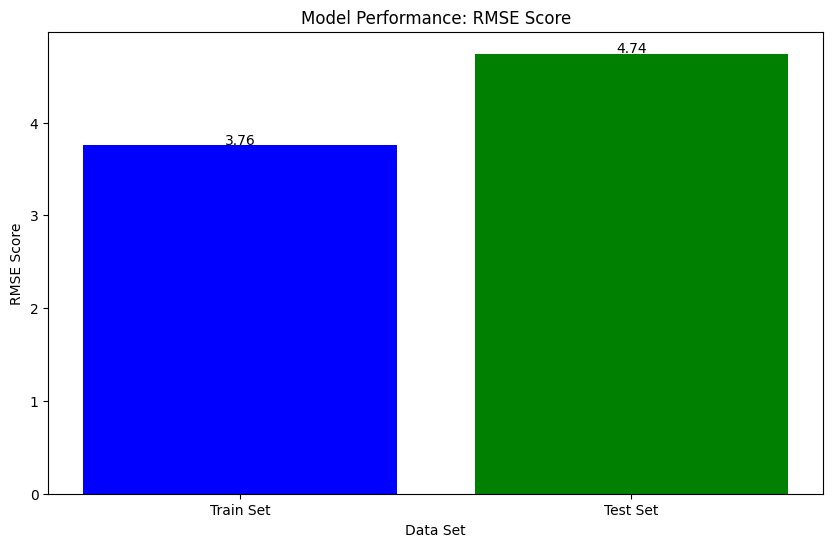

In [11]:
perform_stacking(X_train, y_train, X_test, y_test)

In [ ]:
from models.XGBoost.train_and_evaluate_model import train_and_evaluate_model
from models.XGBoost.tune_xgb_hyperparameters import tune_xgb_hyperparameters
from models.Random_Forest.tune_rf_hyperparameters import tune_rf_hyperparameters
from models.Lasso.tune_lasso_hyperparameters import tune_lasso_hyperparameters
from models.Neural_Network.tune_nn_hyperparameters import tune_nn_hyperparameters
from models.Ridge.tune_ridge_hyperparameters import tune_ridge_hyperparameters
from models.perform_stacking import perform_stacking
from models.optimize_stacking import optimize_stacking

In [ ]:
print(X_train.dtypes)


In [ ]:
X_train = X_train.apply(pd.to_numeric, errors='ignore')


In [ ]:
best_params_rf = tune_rf_hyperparameters(X_train, y_train, 25)

In [ ]:
#Best hyperparameters: {'n_estimators': 266, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None}
# Best RMSE: 5.883527888313719

In [ ]:
best_params_lasso = tune_lasso_hyperparameters(X_train, y_train, X_test, y_test, 100)

In [ ]:
# [I 2023-10-04 17:44:22,225] Trial 23 finished with value: 4.497792051287519 and parameters: {'alpha': 0.08706251396825564}. Best is trial 23 with value: 4.497792051287519.
# Training RMSE: 5.277817560823488, Test RMSE: 4.497792051287519

In [ ]:
best_params_ridge = tune_ridge_hyperparameters(X_train, y_train, X_test, y_test, 100)

In [ ]:
# Best hyperparameters: {'alpha': 0.9992235606570956}
# Best Test RMSE: 5.210845073517565

In [ ]:
best_params_nn = tune_nn_hyperparameters(X_train, y_train, X_test, y_test, 30)

In [ ]:
# Best hyperparameters: {'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'alpha': 0.00010434024177879637}
# Best Test RMSE: 6.9895163966718235

In [ ]:
best_params = tune_xgb_hyperparameters(X_train, y_train, n_trials=30)


In [ ]:
# Best hyperparameters: {'learning_rate': 0.02998822459568964, 'max_depth': 5, 'subsample': 0.7095254982521659, 'colsample_bytree': 0.6113315193397809, 'min_child_weight': 13}
# Best RMSE: 5.098858708449277

In [ ]:
import pickle

import warnings
warnings.filterwarnings("ignore")


In [ ]:
with open('../models/XGBoost/best_params_features_cleaned.pkl', 'rb') as f:
    best_params_xgb = pickle.load(f)

with open('../models/Lasso/best_params_lasso.pkl', 'rb') as f:
    best_params_lasso = pickle.load(f)

with open('../models/Ridge/best_params_ridge.pkl', 'rb') as f:
    best_params_ridge = pickle.load(f)
    
with open('../models/Random_Forest/best_params_rf.pkl', 'rb') as f:
    best_params_rf = pickle.load(f)

with open('../models/Neural_Network/best_params_nn.pkl', 'rb') as f:
    best_params_nn = pickle.load(f)

In [ ]:
best_params = optimize_stacking(X, y, n_trials=25)


In [ ]:
stacking_model, test_rmse = perform_stacking(X, y, best_params_lasso, best_params_rf, best_params_xgb)

In [ ]:
# STACKING MODEL
# base models: ['lasso', 'lasso_lars_cv', 'xgb', 'rf', 'ridge_cv']
# meta model: gradient_boosting_regressor

In [ ]:
# VOTING REGRESSOR
# Root Mean Squared Error (RMSE) for test set: 5.170260299240855
# Root Mean Squared Error (RMSE) for training set: 3.3442587249065046

# ADABOOST REGRESSOR
# Root Mean Squared Error (RMSE) for test set: 4.644395241213758
# Root Mean Squared Error (RMSE) for training set: 2.0869823753568713

# GRADIENT BOOSTING REGRESSOR
# Root Mean Squared Error (RMSE) for test set: 4.496692472551547
# Root Mean Squared Error (RMSE) for training set: 1.653435201586618

# ADA BOOST REGRESSOR
# Root Mean Squared Error (RMSE) for test set: 5.401425699939552
# Root Mean Squared Error (RMSE) for training set: 4.3236806588367855

# LGBM REGRESSOR
# Root Mean Squared Error (RMSE) for test set: 4.546673980636338
# Root Mean Squared Error (RMSE) for training set: 0.2985705242417246

In [ ]:
# open pickle file from the best_params_xgb
with open('../models/XGBoost/best_params_features_cleaned.pkl', 'rb') as f:
    best_params = pickle.load(f)

In [ ]:
bagging_model, rmse_val, feature_importance_df = train_and_evaluate_model(X_train, y_train, X_test, y_test, best_params)

In [ ]:
feature_importance_df

In [ ]:
filtered_feature_importance_df = feature_importance_df[feature_importance_df['Importance'] != 0]


In [ ]:
df

In [ ]:
filtered_feature_importance_df

In [ ]:
filtered_main_df = df.loc[:, filtered_feature_importance_df['Feature'].tolist() + ['total_score']]



In [ ]:
filtered_main_df

In [ ]:
filtered_main_df.to_csv("../data/ready_to_model/filtered_feature_importance_df.csv")

In [ ]:
df

In [ ]:
final_df = fetch_and_merge_data(df)

In [ ]:
df = final_df

In [ ]:
final_df.sample(10)

In [ ]:
# Calculate the percentage of missing values for each column
missing_percent = df_cleaned.isnull().mean() * 100

# Sort the columns by percentage of missing values in descending order
missing_percent_sorted = missing_percent.sort_values(ascending=False)

# Show the sorted series
print(missing_percent_sorted)


In [ ]:
nan_count = final_df.isna().sum()


In [ ]:
def remove_columns_with_nans(df, threshold=800):
    nan_count = final_df.isna().sum()
    columns_to_remove = nan_count[nan_count > threshold].index.tolist()
    df_cleaned = final_df.drop(columns=columns_to_remove)
    return df_cleaned

In [ ]:
df_cleaned = remove_columns_with_nans(df, threshold=300)


In [ ]:
df_cleaned



In [ ]:
df_cleaned.to_csv("../data/ready_to_model/df_cleaned_with_yfinance.csv")

In [ ]:
# Sorting columns by the number of NaN values (in descending order)
sorted_nan_count = nan_count.sort_values(ascending=False)

print(sorted_nan_count.value_counts())

In [ ]:
import pandas as pd

In [ ]:
df_topics = pd.read_csv("../data/ready_to_model/df_cleaned_with_yfinance.csv", index_col=0, parse_dates=True, sep=",")

In [ ]:
df_topics.head()

# CLASSIFICATION

In [ ]:
df_binned = pd.read_csv("../data/ready_to_model/df_filtered_feature_importance.csv")

In [ ]:
# Define the bin edges and labels
bins = [-1, 10, 20, 30, 40, float('inf')]
labels = ['Negligible', 'Low', 'Medium', 'High', 'Severe']

# Create a new column with the binned categories
df_binned['score_class'] = pd.cut(df_binned['total_score'], bins=bins, labels=labels, right=True)


In [ ]:
df_binned.sample(10).head()

In [ ]:
df_binned.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df_binned.to_csv("../data/ready_to_model/df_binned.csv")